In [5]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
    os.chdir('..')

import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd

from torchvision.transforms import v2
from sklearn.manifold import TSNE

from src.data_manager import init_data
from src.msn_train import init_model

../data/training_patches/temperature_3p.npy


/home/livia/miniconda3/envs/tf/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


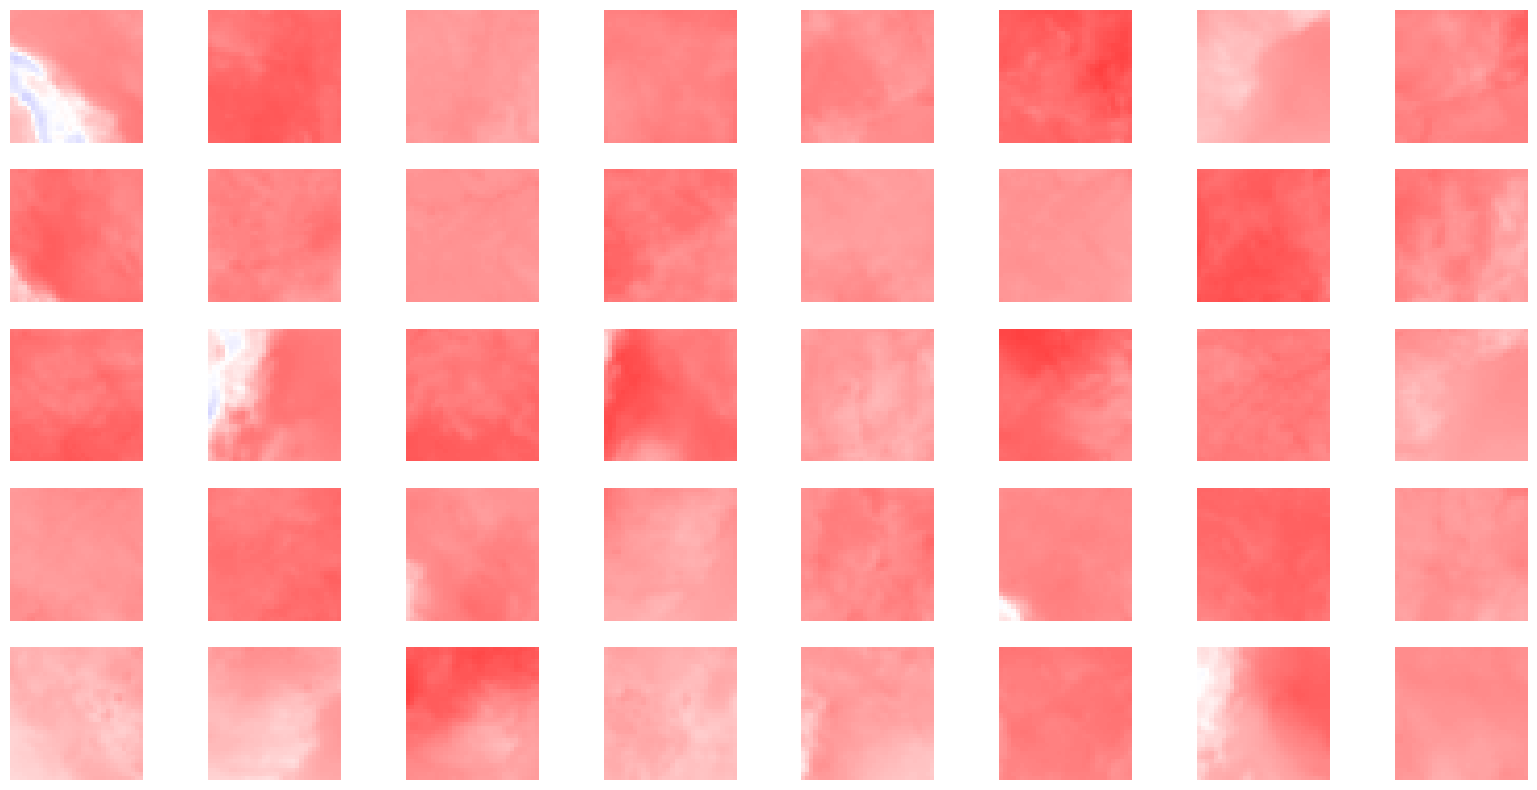

In [4]:
# Create the data loader and display some images

with open("./configs/msn_vits16.yaml", 'r') as y_file:
    params = yaml.load(y_file, Loader=yaml.FullLoader)
    print(params['data']['image_folder'])


transform = v2.Compose([
    v2.RandomResizedCrop(size=params['data']['rand_size'], scale=(0.9, 1.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),

])
    
(unsupervised_loader, unsupervised_sampler) = init_data(
    transform=transform,
    batch_size=40,
    image_folder=params['data']['image_folder'],
    dataset_size=5000
)

images, _ = next(iter(unsupervised_loader))
fig, axes = plt.subplots(5, 8, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0],cmap='bwr',vmin=0, vmax=1)
    ax.axis("off")

In [8]:
# Create the encoder and load the latest checkpoint

target_encoder = init_model(
    device = "cuda:0",
    model_name = params['meta']['model_name'],
    use_bn = params['meta']['use_bn'],
    hidden_dim = params['meta']['hidden_dim'],
    output_dim = params['meta']['output_dim'],
    drop_path_rate = params['meta']['drop_path_rate'],
)


latest_checkpoint = os.path.join(params['logging']['folder'], params['logging']['write_tag'] + "-ep75.pth.tar")
checkpoint = torch.load(latest_checkpoint, map_location='cpu')

target_encoder.load_state_dict(checkpoint['target_encoder'], strict=False)
target_encoder.eval()

prot = checkpoint['prototypes'].to("cuda:0")
prot = torch.nn.functional.normalize(prot)
prot.shape

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (fc): Sequent

/tmp/ipykernel_192475/2744319064.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint, map_location='cpu')


torch.Size([60, 256])

In [9]:
# Encode the images

E = torch.empty(0, params['meta']['output_dim']).to("cuda:0") # encodings
F = torch.empty(0, prot.shape[0]).to("cuda:0")                # prototypes
L = torch.empty(0).to("cuda:0")                               # labels
with torch.no_grad():
    for img, lab in unsupervised_loader.dataset:
        img = img.unsqueeze(0).to("cuda:0")
        img = transform(img)
        enc = target_encoder(img)
        enc = torch.nn.functional.normalize(enc)
        E = torch.cat((E, enc), 0)
        F = torch.cat((F, enc @ prot.T), 0)
        L = torch.cat((L, lab.unsqueeze(0).to("cuda:0")), 0)

print(E.shape, F.shape, L.shape)

torch.Size([5000, 256]) torch.Size([5000, 60]) torch.Size([5000])


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.001465
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.588570
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


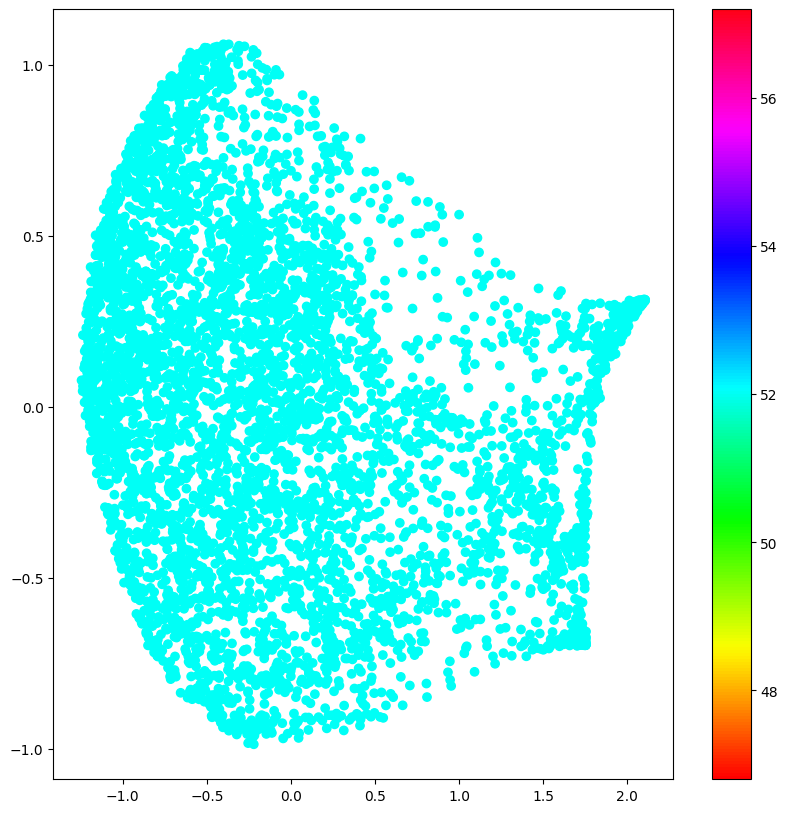

In [10]:
# Plot the t-SNE of the encodings

tsne = TSNE(n_components=2, verbose=1, perplexity=50, max_iter=250)
tsne_results = tsne.fit_transform(E.cpu().numpy())

color = F.argmax(dim=1).cpu().numpy() # color is the closest prototype
#color = L.cpu().numpy()              # color is the dataset label

plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=color, cmap='hsv')
plt.colorbar()
plt.show()

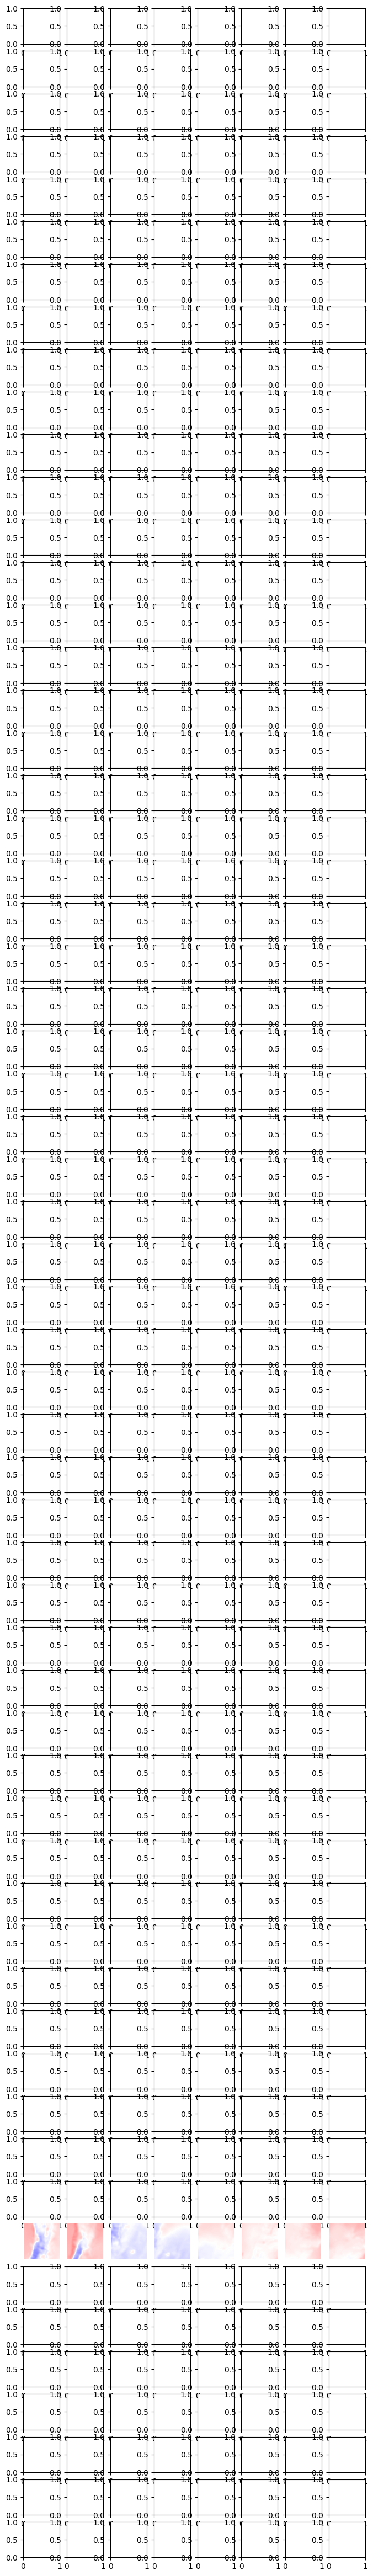

In [11]:
# Plot the images of the top 8 predictions of each cluster

Top = 8

max_val, max_idx = torch.max(F, dim=1)
df = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})

fig, axes = plt.subplots(params['criterion']['num_proto'], Top, figsize=(Top, params['criterion']['num_proto']))
for i in range(params['criterion']['num_proto']):
    top5 = df[df["max_idx"] == i].nlargest(Top, "max_val")

    for j, im in enumerate(top5.index):
        ax = axes[i, j]
        image = unsupervised_loader.dataset[im][0][0]

        ax.imshow(image,cmap='bwr',vmin=0, vmax=1)
        ax.axis("off")
        
plt.show()